Ссылка на github: https://github.com/Gen4ick/first_project/issues/1

# Проект: Обучение с учителем: качество модели "в один клик"

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Цель исследования

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами

### Основные задачи исследования

Нам потребуется предобработать данные, провести базовый исследовательский анализ и обучить модель для предсказания поведения покупателя

### Исходные данные

Нам даны три таблицы: первая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, вторая содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом, третья содержит данные о среднемесячной прибыли продавца за последние 3 месяца, то есть какую прибыль получает магазин от продаж каждому покупателю.

# Шаг 1. Загрузка данных

Начинаем проект с того, что подключаем нужные нам библиотеки

In [1]:
!pip install shap -q

In [2]:
!pip install phik -q

In [3]:
!pip install scikit-learn==1.1.3 -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats

from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from statistics import stdev

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.metrics import f1_score, precision_score, roc_auc_score, make_scorer


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

Теперь пора считать данные

In [5]:
df_main = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_time = pd.read_csv('/datasets/market_time.csv')
df_money = pd.read_csv('/datasets/money.csv',sep=';')

Ознакомиммся с данными

In [6]:
display(df_main.head(5))
display(df_market_money.head(5))
display(df_time.head(5))
display(df_money.head(5))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Данные корректно считались и соответствуют описанию

# Шаг 2. Предобработка данных

Базово изучим датафреймы

In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


По типам данных почти все хорошо столбец с прибылью в четвертой таблице надо перевести в float

In [11]:
df_money['Прибыль'] = df_money['Прибыль'].str.replace(',','.')
df_money['Прибыль'] = df_money['Прибыль'].astype('float')
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Посмотрим как обстоят дела с пропусками

In [12]:
print(df_main.isna().sum())
print()
print(df_market_money.isna().sum())
print()
print(df_time.isna().sum())
print()
print(df_money.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64


Пропусков не наблюдается, тогда переходим к проверке на дубликаты и неявные дубликаты

In [13]:
print(df_main.duplicated().sum())
print()
print(df_market_money.duplicated().sum())
print()
print(df_time.duplicated().sum())
print()
print(df_money.duplicated().sum())

0

0

0

0


Явных дубликатов не нашлось, проверим наличие неявных, начнем с первой таблицы

In [14]:
print(df_main['Покупательская активность'].value_counts())
print()
print(df_main['Тип сервиса'].value_counts())
print()
print(df_main['Разрешить сообщать'].value_counts())
print()
print(df_main['Популярная_категория'].value_counts())
print()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64



пупупу в столбце с типом сервиса есть неявный дубликат, сейчас все поправим

In [15]:
df_main['Тип сервиса'] = df_main['Тип сервиса'].str.replace('стандартт','стандарт')

Теперь проверим вторую и третью таблице

In [16]:
print(df_time['Период'].value_counts())
print()
print(df_market_money['Период'].value_counts())

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: Период, dtype: int64


Есть несоответствие в названии одного из значений столбца с периодом в таблице со временем

In [17]:
df_time['Период'] = df_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')

По итогу предобработки данных было проверено наличие пропусков(не нашлись), наличие явных дубликатов(не нашлись), в столбце с типом сервиса из первой таблицы было найдено некоторые количество неявных дубликатов, столбец с прибылью в последней таблице был в некорректном формате.

# Шаг 3. Исследовательский анализ данных

Исследовательский анализ данных мы будем делать поэтапно, начиная с первой таблицы, для нее мы построим диаграммы размаха, выкинем все выбросы в количественных признаках, построим для них же гистограммы и построим распределения для категориальных признаков.

Разобьем признаки на количественные и категориальные

In [18]:
df_main_num_col = ['Маркет_актив_6_мес',
                  'Маркет_актив_тек_мес',
                  'Длительность',
                  'Акционные_покупки',
                  'Средний_просмотр_категорий_за_визит',
                  'Неоплаченные_продукты_штук_квартал',
                  'Ошибка_сервиса',
                  'Страниц_за_визит']

df_main_cat_col = ['Покупательская активность',
                  'Тип сервиса',
                  'Разрешить сообщать',
                  'Популярная_категория']

Теперь для количественных признаков построим диаграммы размаха

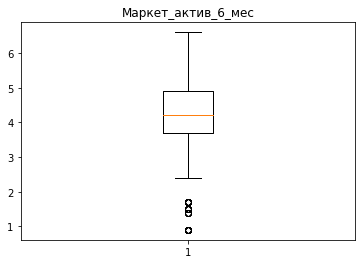

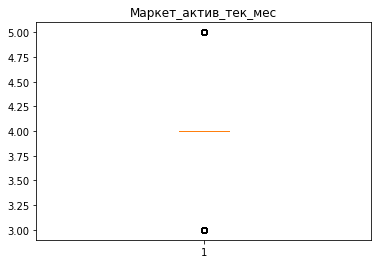

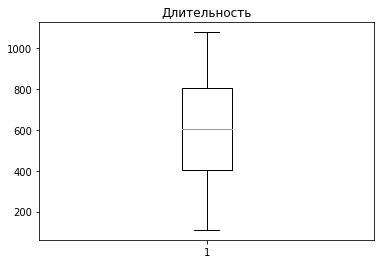

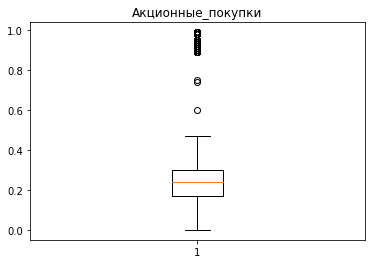

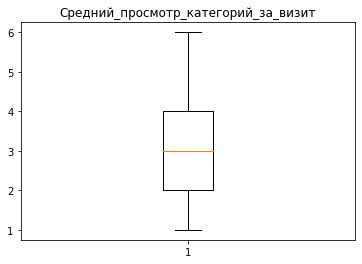

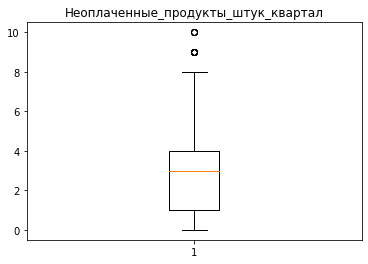

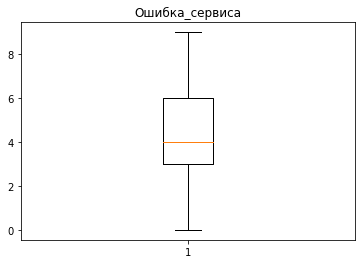

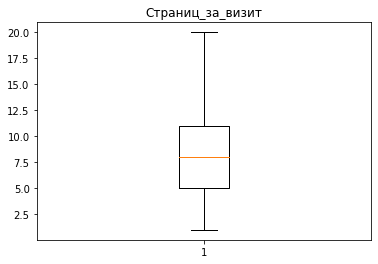

In [19]:
for column in df_main_num_col:
    plt.title(column)
    plt.boxplot(df_main[column])
    plt.show()

Построим гистограммы для количественных признаков, а также проведем статистический тест на схожесть с нормальным распределением, начнем с непрерывных признаков

Распределение непрерывных количественных признаков


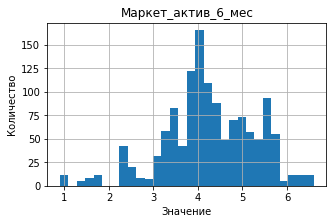

Нулевая гипотеза не подтвердилась


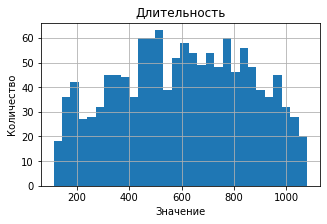

Нулевая гипотеза не подтвердилась


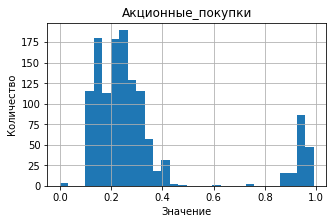

Нулевая гипотеза не подтвердилась


In [20]:
df_main_interval_cols = ['Маркет_актив_6_мес',
                         'Длительность', 
                         'Акционные_покупки']

print('Распределение непрерывных количественных признаков')
for column in df_main_interval_cols:
    df_main[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();
    if stats.kstest(df_main[column], 'norm', args=(df_main[column].mean(),stdev(df_main[column])), alternative='two-sided').pvalue>0.05:
        print('распределение нормальное')
    else:
        print('Нулевая гипотеза не подтвердилась')

p-value меньше 0,05 у всех построенных распределений, следовательно мы не можем отнести их к нормальному распределению, хотя визульная схожесть есть у всех кроме акционных покупок, все равно нельзя утверждать принадлежность распределений признаков к нормальному распределению

Теперь настала очередь дискретных

Распределение дискретных количественных признаков


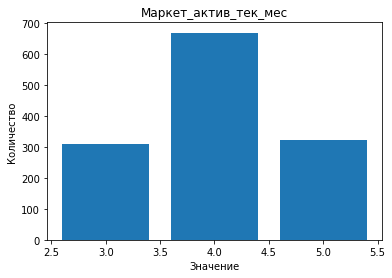

Нулевая гипотеза не подтвердилась


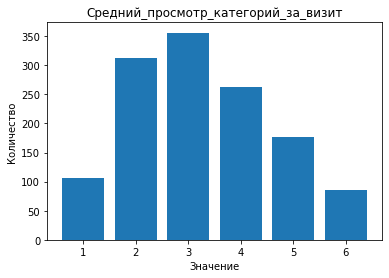

Нулевая гипотеза не подтвердилась


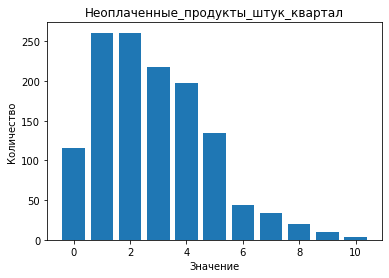

Нулевая гипотеза не подтвердилась


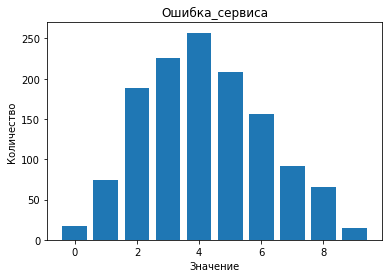

Нулевая гипотеза не подтвердилась


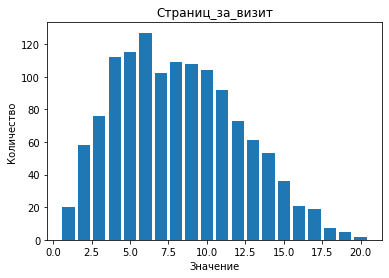

Нулевая гипотеза не подтвердилась


In [21]:
df_main_diskret_cols = ['Маркет_актив_тек_мес',
                        'Средний_просмотр_категорий_за_визит',
                        'Неоплаченные_продукты_штук_квартал',
                        'Ошибка_сервиса',
                        'Страниц_за_визит']

n = {'Маркет_актив_тек_мес':3,
     'Средний_просмотр_категорий_за_визит':6,
     'Неоплаченные_продукты_штук_квартал':10,
     'Ошибка_сервиса':9,
     'Страниц_за_визит':20}

print('Распределение дискретных количественных признаков')
for column in df_main_diskret_cols:
    plt.bar(df_main[column].value_counts().index, df_main[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();
    if stats.kstest(df_main[column], 'norm', args=(df_main[column].mean(),stdev(df_main[column])), alternative='two-sided',N=n[column]).pvalue>0.05:
        print('распределение нормальное')
    else:
        print('Нулевая гипотеза не подтвердилась')

Идентичная ситуация, статистический тест утверждает, что мы не можем отнести эти распределения к нормальным, но все равно визуальная схожесть присутствует

Все количественные признаки в данном случае имеют близкое к нормальному распредление, кроме акционных покупок, оно из себя представляет два ярковыраженных пиках рядом со значением 1 и 0.2

Рассмотрим распределение качественных признаков

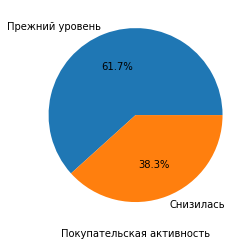

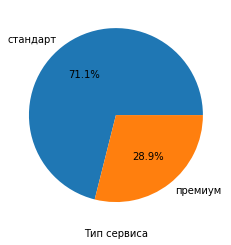

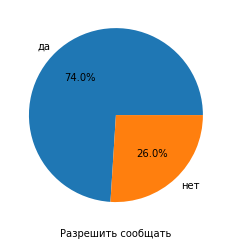

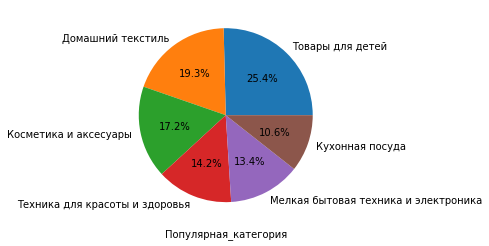

In [22]:
for column in df_main_cat_col:
    plt.pie(df_main[column].value_counts().values, labels=df_main[column].value_counts().index,autopct='%1.1f%%')
    plt.xlabel(column)
    plt.show()

Покупательская активность в большинстве своем осталась на прежнем уровне, большинство людей пользуется стандартным типом сервиса и разрешают присылать себе маркетинговые предложения. Категории распределяются довольно равно, но все равно можно выделить самые многочисленные - товары для детей, домашний текстиль и косметику и аксесуары

Перейдем ко второй таблице с данными о выручке, проделаем с ней аналогичные операции

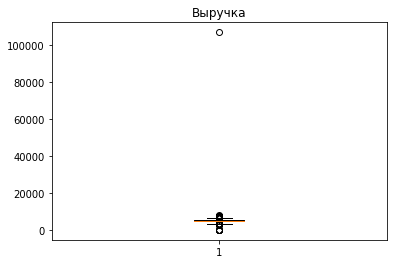

In [23]:
plt.title('Выручка')
plt.boxplot(df_market_money['Выручка'])
plt.show()

В данном случае лучше избавиться только от выброса выходящего за 10000 и равного нулю, остальные оставить, так как они довольно многочисленные

In [24]:
df_market_money = df_market_money[df_market_money['Выручка']<80000]
df_market_money = df_market_money[df_market_money['Выручка']>0]

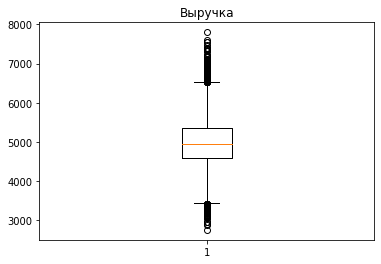

In [25]:
plt.title('Выручка')
plt.boxplot(df_market_money['Выручка'])
plt.show()

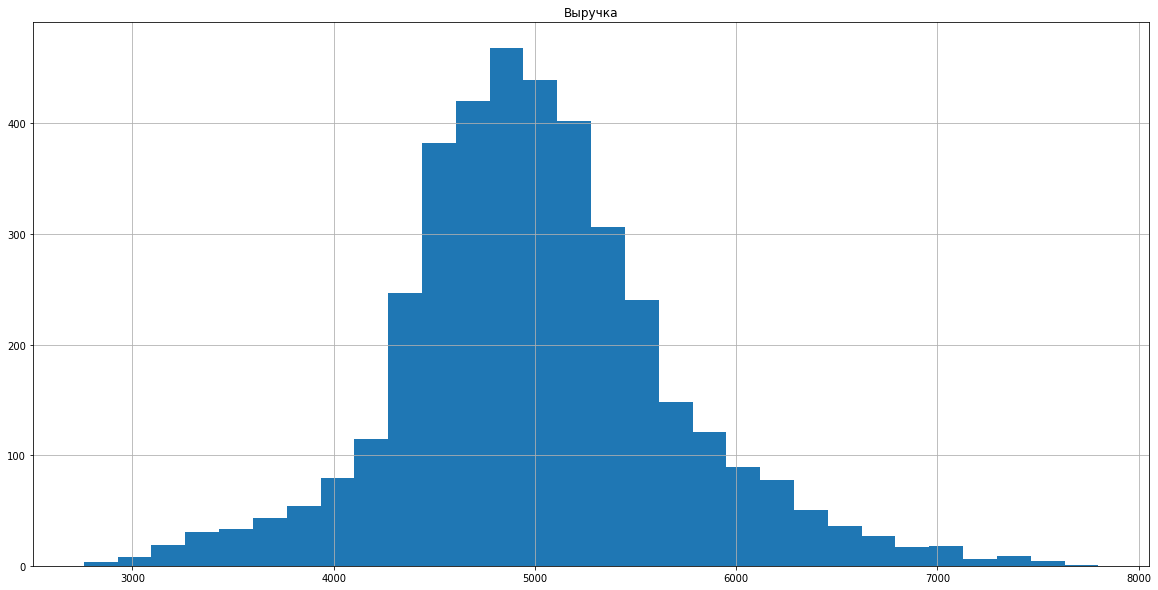

Нулевая гипотеза не подтвердилась


In [26]:
df_market_money['Выручка'].hist(figsize=(20,10),bins=30)
plt.title('Выручка')
plt.show()
if stats.kstest(df_market_money['Выручка'], 'norm', args=(df_market_money['Выручка'].mean(),stdev(df_market_money['Выручка'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Избавились от выбросов, p-value все еще меньше 0.05, но есть визуальное сходство

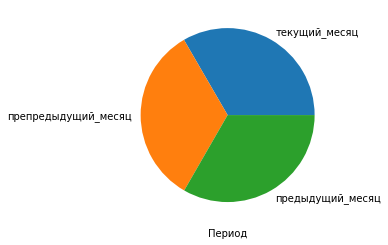

In [27]:
plt.pie(df_market_money['Период'].value_counts().values, labels=df_market_money['Период'].value_counts().index)
plt.xlabel('Период')
plt.show()


Все месяцы равномерно распределены

Перейдем к третьей таблице со временем проведенным на сайте в течение периода

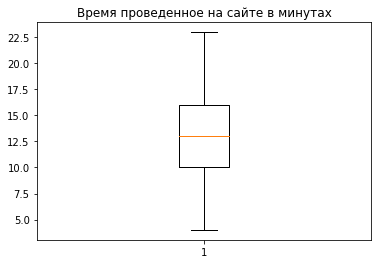

In [28]:
plt.title('Время проведенное на сайте в минутах')
plt.boxplot(df_time['минут'])
plt.show()

Нет выбросов - нет проблем, можно строить гистограмму

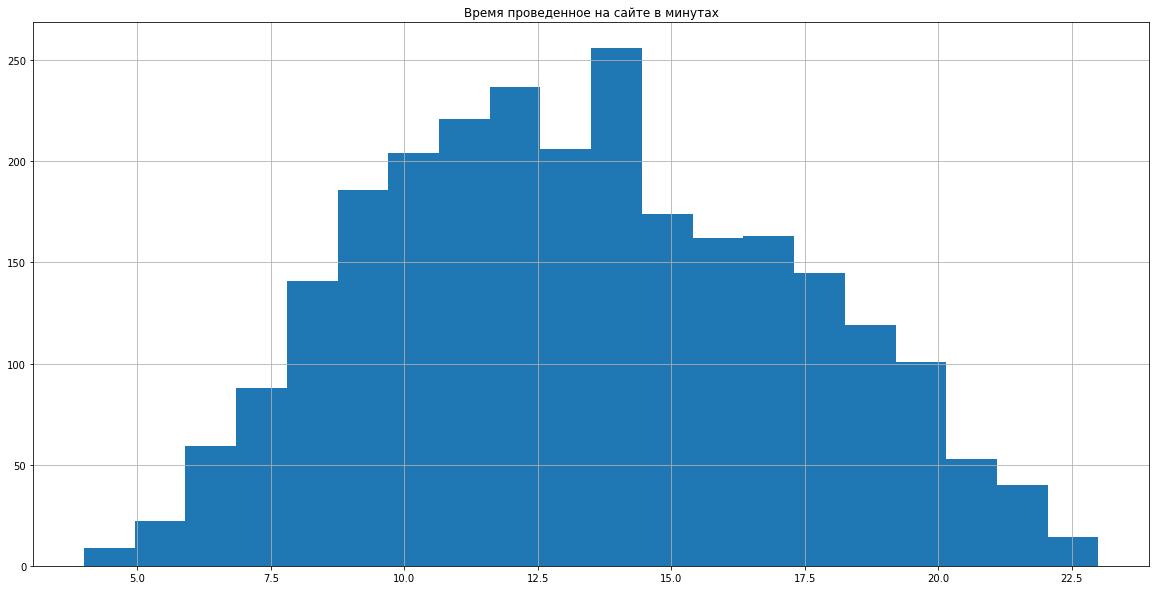

Нулевая гипотеза не подтвердилась


In [29]:
df_time['минут'].hist(figsize=(20,10),bins=20)
plt.title('Время проведенное на сайте в минутах')
plt.show()
if stats.kstest(df_time['минут'], 'norm', args=(df_time['минут'].mean(),stdev(df_time['минут'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Время проведенное на сайте имеет p-value меньше 0.05, но все равно близко к нормальному по картинке, давайте разберемся с периодом аналогично второй таблице

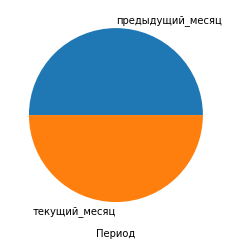

In [30]:
plt.pie(df_time['Период'].value_counts().values, labels=df_time['Период'].value_counts().index)
plt.xlabel('Период')
plt.show()

Распределение общего времени по периодам является равномерным

Теперь очередь дошла до 4 таблицы

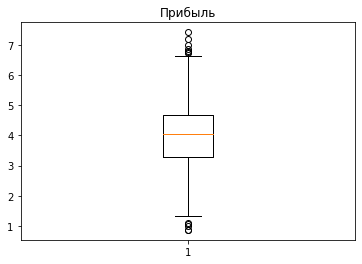

In [31]:
plt.title('Прибыль')
plt.boxplot(df_money['Прибыль'])
plt.show()

Нашлись выбросы, в данном случае можно их не щадить и убрать

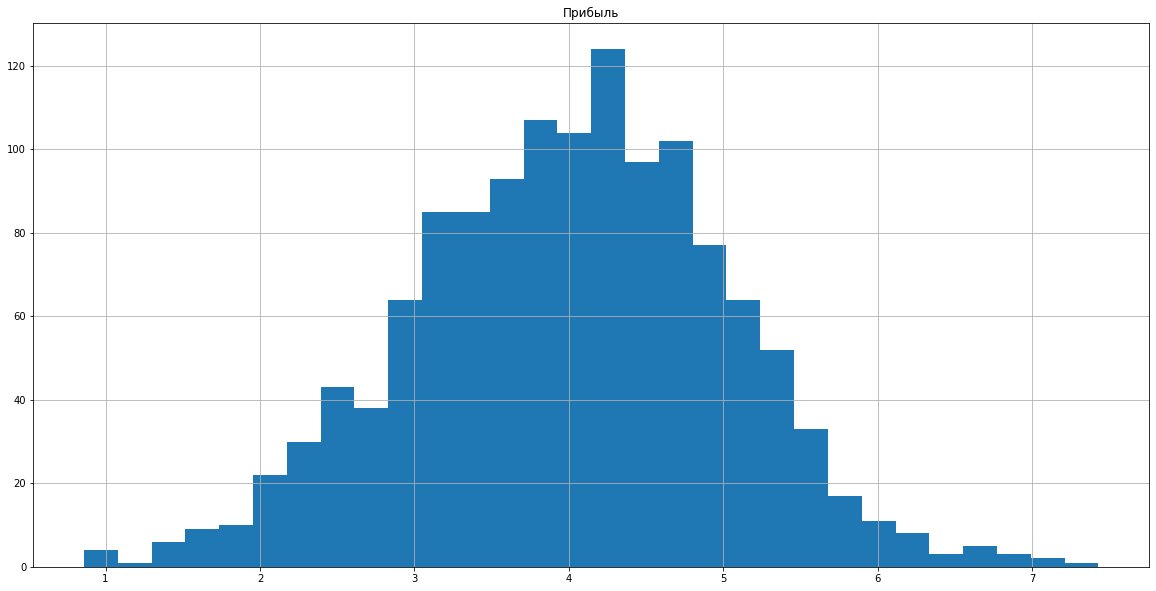

распределение нормальное


In [32]:
df_money['Прибыль'].hist(figsize=(20,10),bins=30)
plt.title('Прибыль')
plt.show()
if stats.kstest(df_money['Прибыль'], 'norm', args=(df_money['Прибыль'].mean(),stdev(df_money['Прибыль'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Распределение прибыли продавца за последние три месяца является нормальным

По итогу исследовательского анализа данных можно сказать, что подавляющее большинство количественным признаков не имеет нормальное распределение, кроме прибыли последней таблице. В плане категориальных признаков в первой таблице преобладал прежний уровень активности у клиента, так же большинство клиентов пользуется стандартным типом сервиса и разрешает присылать им маркетинговые прдложения. С точки зрения заинтересованности категориями товаров, все они распределены равномерно. в остальных таблицах количественные признаки имеют нормальное распределение. Периоды в талице со временем и выручкой распределены равно по понятным причинам

# Шаг 4. Объединение таблиц

Давайте объединим три основные таблицы в одну, четвертую не трогаем, так как она нам не понадобится

In [33]:
df_time_tek = df_time[df_time['Период']=='текущий_месяц']
df_time_tek = df_time_tek.drop('Период',axis=1)
df_time_pred = df_time[df_time['Период']=='предыдущий_месяц']
df_time_pred = df_time_pred.drop('Период',axis=1)

df_market_money_tek = df_market_money[df_market_money['Период']=='текущий_месяц']
df_market_money_tek = df_market_money_tek.drop('Период',axis=1)
df_market_money_pred = df_market_money[df_market_money['Период']=='предыдущий_месяц']
df_market_money_pred = df_market_money_pred.drop('Период',axis=1)
df_market_money_prepre = df_market_money[df_market_money['Период']=='препредыдущий_месяц']
df_market_money_prepre = df_market_money_prepre.drop('Период',axis=1)

In [34]:
df_main = pd.merge(df_main,df_time_tek,on='id',how='left')
df_main = pd.merge(df_main,df_time_pred,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_tek,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_pred,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_prepre,on='id',how='left')

df_main = df_main.rename(columns={'минут_x':'Время_за_текущий_месяц',
                                  'минут_y':'Время_за_предыдущий_месяц',
                                  'Выручка_x':'Выручка_за_текущий_месяц',
                                  'Выручка_y':'Выручка_за_предыдущий_месяц',
                                  'Выручка':'Выручка_за_препредыдущий_месяц',})

display(df_main)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_за_текущий_месяц,Время_за_предыдущий_месяц,Выручка_за_текущий_месяц,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,14,13,3293.1,NaN,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10,12,4971.6,5216.0,4472.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,13,8,5058.4,5457.5,4826.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,13,11,6610.4,6158.0,4793.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11,8,5872.5,5807.5,4594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,7,14,4741.7,3664.0,4704.0
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,11,12,5353.0,4729.0,5299.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,18,12,5139.2,5160.0,5334.0
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,7,18,5224.6,4923.0,4725.0


Появились пропуски, но ничего, мы их потом в шаге с пайплайнами заполним средним значением

# Шаг 5. Корреляционный анализ данных

In [35]:
df_main_interval_col = ['Маркет_актив_6_мес',
                  'Длительность',
                  'Акционные_покупки',
                  'Время_за_текущий_месяц',
                  'Время_за_предыдущий_месяц',
                  'Выручка_за_текущий_месяц',
                  'Выручка_за_предыдущий_месяц',
                  'Выручка_за_препредыдущий_месяц']


In [36]:
df_main.drop('id',axis=1).phik_matrix(interval_cols=df_main_interval_col)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_за_текущий_месяц,Время_за_предыдущий_месяц,Выручка_за_текущий_месяц,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц
Покупательская активность,1.000000,0.132277,0.000000,0.545630,0.000000,0.089995,0.498954,0.297053,0.535431,0.402574,0.219823,0.748398,0.575876,0.683726,0.197806,0.227280,0.495174
Тип сервиса,0.132277,1.000000,0.286015,0.092477,0.044600,0.405711,0.046192,0.066787,0.181069,0.114099,0.073367,0.088330,0.000000,0.129821,0.121108,0.000000,0.068507
Разрешить сообщать,0.000000,0.286015,1.000000,0.000000,0.052267,0.249165,0.000000,0.071386,0.071829,0.162462,0.000000,0.096469,0.000000,0.041988,0.062021,0.079830,0.000000
Маркет_актив_6_мес,0.545630,0.092477,0.000000,1.000000,0.078349,0.000000,0.241500,0.149938,0.206398,0.215234,0.141742,0.373082,0.328372,0.363694,0.035866,0.149129,0.312243
Маркет_актив_тек_мес,0.000000,0.044600,0.052267,0.078349,1.000000,0.178717,0.011341,0.132810,0.247489,0.144497,0.115543,0.000000,0.064532,0.103696,0.000000,0.054683,0.000000
Длительность,0.089995,0.405711,0.249165,0.000000,0.178717,1.000000,0.124509,0.000000,0.191292,0.115885,0.185802,0.111171,0.106626,0.000000,0.141601,0.116325,0.112349
Акционные_покупки,0.498954,0.046192,0.000000,0.241500,0.011341,0.124509,1.000000,0.102826,0.196895,0.245399,0.079912,0.343749,0.264620,0.261309,0.087261,0.056164,0.191116
Популярная_категория,0.297053,0.066787,0.071386,0.149938,0.132810,0.000000,0.102826,1.000000,0.224104,0.254464,0.000000,0.175765,0.091974,0.195037,0.235239,0.250974,0.045814
Средний_просмотр_категорий_за_визит,0.535431,0.181069,0.071829,0.206398,0.247489,0.191292,0.196895,0.224104,1.000000,0.335158,0.067988,0.291334,0.183393,0.158577,0.101008,0.100332,0.176770
Неоплаченные_продукты_штук_квартал,0.402574,0.114099,0.162462,0.215234,0.144497,0.115885,0.245399,0.254464,0.335158,1.000000,0.016883,0.307712,0.168824,0.195247,0.165441,0.193752,0.189721


Исходя из таблицы корреляций можно сказать, что нет признаков, которые имеют мультиколлинеарность

# Шаг 6. Использование пайплайнов

На данном этапе используя пайплайны мы переберем модели, гиперпараметры к ним, методы обработки данных и найдем самое оптимальное сочетание, которое дает наибольшую точность.

С точки зрения машинного обучения мы имеем дело с задачей бинарной классификации, поэтому будут использоваться модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC()

В нашем случае очевидно, что нам важнее всего избежать ложноположительных ошибок, так как самое главное это найти всех клиентов, у которых может снизиться активность, то есть нас интересует метрика precision

Для начала разделим наши данные на выборки и отсортируем признаки на категории для подготовки к обучению модели

In [37]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df_main.drop(['Покупательская активность','id'],axis=1)
y = df_main['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=df_main['Покупательская активность'])


ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns = df_main.drop(['Популярная_категория',
                            'Тип сервиса',
                            'Разрешить сообщать',
                            'Покупательская активность',
                            'id'],axis=1).columns


Избавимся от выбросов в числовых признаках

In [38]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train[num_columns] = num_imputer.fit_transform(X_train[num_columns])
X_test[num_columns] = num_imputer.transform(X_test[num_columns])

Напишем часть пайплайна для OneHotEncoder

In [39]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

Напишем часть пайплайна для OrdinalEncoder

In [40]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Объединим эти пайалайны в один по подготовке данных

In [41]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
    
)
data_preprocessor.fit(X_train)
ohe_transformer = data_preprocessor.named_transformers_['ohe'].named_steps['ohe']
new_column_names = ohe_transformer.get_feature_names_out(ohe_columns)

Пишем финальный пайплайн и параметры для перебора

In [42]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

Производим перебор

In [43]:
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=make_scorer(precision_score, average='binary',pos_label='Снизилась'),
    random_state=RANDOM_STATE,
    n_jobs=-1
)
r_search.fit(X_train, y_train)
print('Лучшая модель')
print()
print(r_search.best_estimator_)
print()
print ('Метрика лучшей модели', r_search.best_score_)
print()
print(r_search.best_params_)

preds = r_search.predict(X_test)

print(preds)

Лучшая модель

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [44]:
best_pipeline = r_search.best_estimator_ 
model = best_pipeline.named_steps['models']

Модель показывает хороший результат, была выбрана по итогу модель KneighboresClassifier с 2 ближайшими соседями, причем лучший результат показала модель при стандартизации StandardScaler()

# Шаг 7. Анализ важности признаков

Модель была выбранна нелинейная, поэтому использования метода Шепли невозможно, поэтому воспользуемся старым добрым удалением признаков

In [45]:
new_cols = ['Тип Сервиса',
            'Разрешить сообщать',
            'Маркет_актив_6_мес',
            'Маркет_актив_тек_мес',
            'Длительность',
            'Акционные_покупки',
            'Популярная_категория_Косметика и аксесуары',
            'Популярная_категория_Кухонная посуда',
            'Популярная_категория_Мелкая бытовая техника и электроника',
            'Популярная_категория_Техника для красоты и здоровья',
            'Популярная_категория_Товары для детей',
            'Средний_просмотр_категорий_за_визит',
            'Неоплаченные_продукты_штук_квартал',
            'Ошибка_сервиса',
            'Страниц_за_визит',
            'Время_за_текущий_месяц',
            'Время_за_предыдущий_месяц',
            'Выручка_за_текущий_месяц',
            'Выручка_за_предыдущий_месяц',
            'Выручка_за_препредыдущий_месяц']

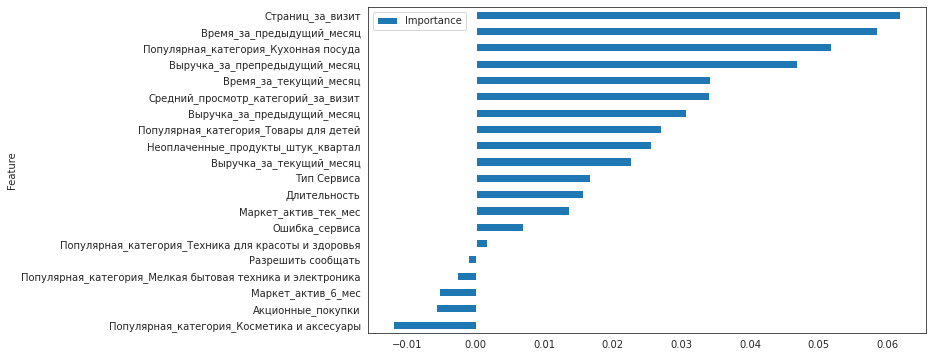

In [46]:
X_train = data_preprocessor.fit_transform(X_train)
X_test = data_preprocessor.transform(X_test)
X_train = pd.DataFrame(X_train,columns=new_cols)
X_test = pd.DataFrame(X_test,columns=new_cols)
model.fit(X_train,y_train)
features_names = X_train.columns
result = permutation_importance(model, X_test, y_test, scoring=make_scorer(precision_score, average='binary',pos_label='Снизилась'),n_repeats=20,random_state=RANDOM_STATE)

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)); 


Наиболее влиятельными на вердикт модели оказались признаки просмотра странниц, средний просмотр категорий за визит и время за препредыдущий месяц, также некоторые признаки получили отрицательную важность.

# Шаг 8. Сегментация покупателей

Как изучаемый сегмент было принято решение взять покупателей со сниженной активностью, так как вне зависимости от благосостояния клиента мы не хотим его терять и сохранять его вовлеченность в наш сайт. В первую очередь анализ будет основан на том, что модель посчитала самыми важными для вынесения вердикта признаками.

In [47]:
df_main = pd.merge(df_main,df_money,on='id',how='left')
df_main_interval_cols = ['Маркет_актив_6_мес',
                         'Длительность', 
                         'Акционные_покупки',
                         'Прибыль']
df_main_down = df_main[df_main['Покупательская активность']=='Снизилась'].drop('id',axis=1)
df_main_same = df_main[df_main['Покупательская активность']=='Прежний уровень'].drop('id',axis=1)

Распределение непрерывных количественных признаков среди покупателей со сниженной активностью


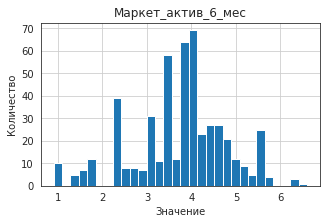

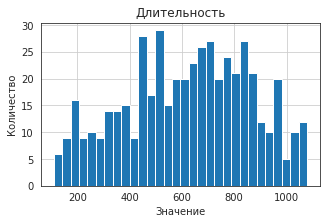

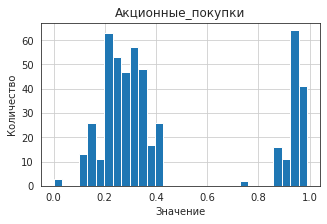

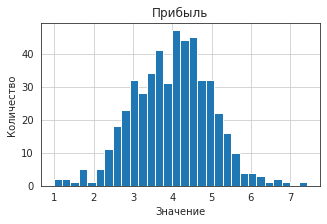

In [48]:
print('Распределение непрерывных количественных признаков среди покупателей со сниженной активностью')
for column in df_main_interval_cols:
    df_main_down[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение дискретных количественных признаков среди покупателей со сниженной активностью


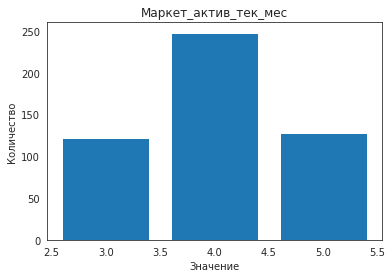

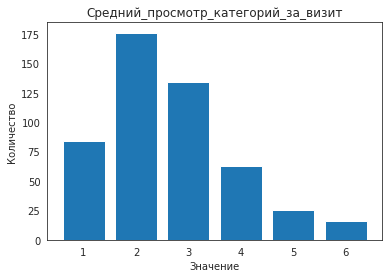

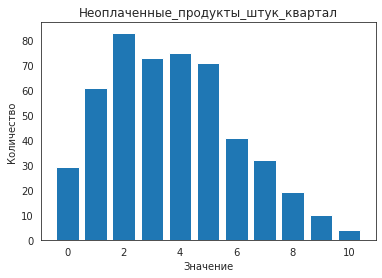

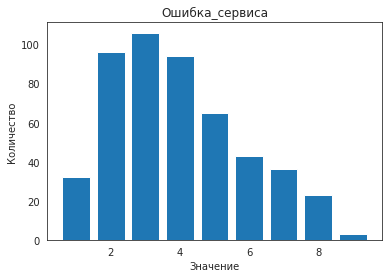

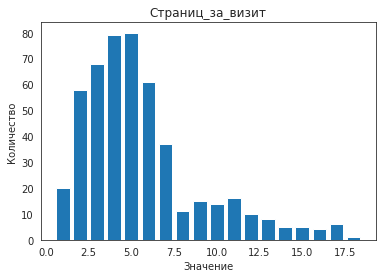

In [49]:
print('Распределение дискретных количественных признаков среди покупателей со сниженной активностью')
for column in df_main_diskret_cols:
    plt.bar(df_main_down[column].value_counts().index, df_main_down[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение непрерывных количественных признаков среди покупателей с прежней активностью


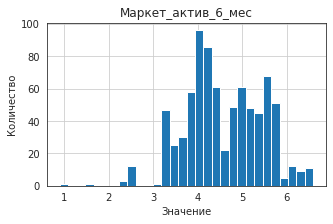

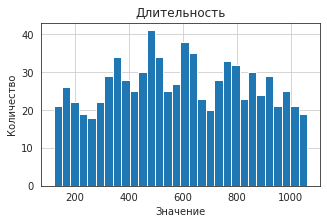

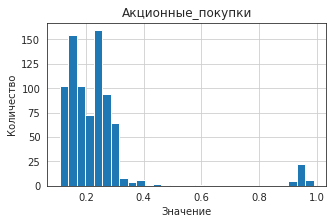

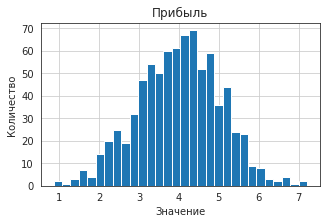

In [50]:
print('Распределение непрерывных количественных признаков среди покупателей с прежней активностью')
for column in df_main_interval_cols:
    df_main_same[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение дискретных количественных признаков среди покупателей с прежней активностью


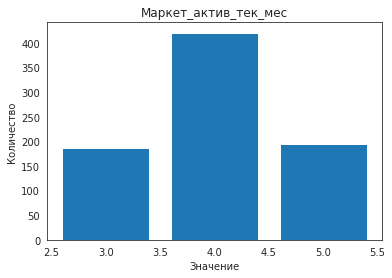

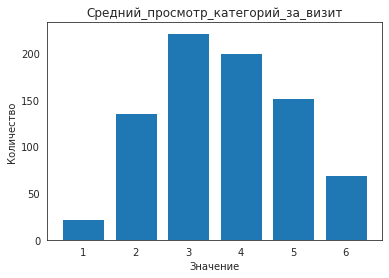

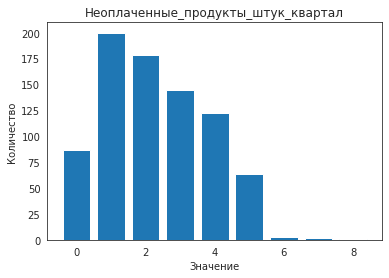

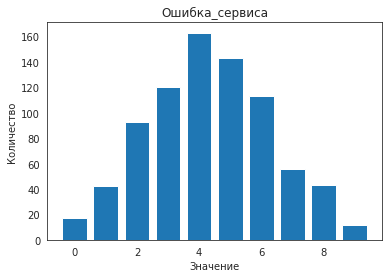

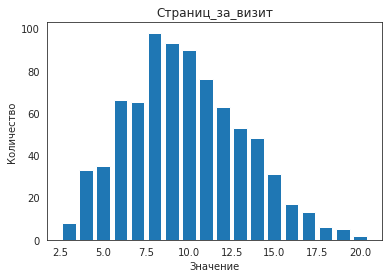

In [51]:
print('Распределение дискретных количественных признаков среди покупателей с прежней активностью')
for column in df_main_diskret_cols:
    plt.bar(df_main_same[column].value_counts().index, df_main_same[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Самым важным признаком для модели оказались прочитанные странницы за визит, у клиентов со сниженной активностью пик сдвинут в сторону более маленьких значений, что означает, что нам следует внедрить алгоритмы, которые будут держать внимание клиента и он бы не закрывал сайт, после пары просмотренных странниц

Основное распределение времени на сайте у пользователей со сниженной активностей в текущем и предыдущем периоде сдвинут в сторону более маленьких чисел. То же самое можно сказать о просмотре разных категорий и странниц за один визит. Также у людей со сниженной активностью есть пик в единице на признаке доли акционных покупок.

На основе вышесказанного можно утверждать, что сайту требуется улучшить свои системы рекомендаций, чтоды удерживать целевую аудиторию, чтобы учеличить время проведенное на сайте и количество странниц. Также, мы видим, что в акциях наиболее заинтересованна аудитория со сниженной активностью, возможно стоит увеличить количество предлагаемых акций и разработать модель по целесообразности выдавания тому или иному клиенту акции на интересующую его категорию, так как мы не хотим выдавать  акции всем, так как это может привести к потере аудитории

# Шаг 9. Итоговый вывод

На первом шагу мы считали данные, данные считались нормально, почти все признаки имели тот тип данных, который нужно(кроме одного)

На втором шагу выполнялась предобработка данных. В четвертой таблицы с прибылью продавца требовалось сменить данных на числовой с плавающей запятой. Далее данные были проверены на пропуски и явные и неявные дубликаты. Нашлось только немного неявных дубликатах, которые мы исправили

Третий шаг это исследовательский анализ данных. На этом этапе мы ждя всех количественных признаков построили диаграммы размаха и на основе их избавились от выбросов, далее построили гистрограммы и проанализировали распределения, которые в основном были нормальные, за парой исключений, например акционные покупки, которые также имели пик в единице.

Четвертый шаг это объединение таблиц. На данном этапе нам требовалось соединить три таблицы(основная таблица с поведением покупателя, таблица с выручкой с покупателя, таблица с временм проведенном на сайте для каждого покупателя), под каждый период была сделана отдельная колонка.

Пятый шаг это корреляционный анализ, была построена матрица корреляций Фика и по итогу анализа, мы пришли к выводу, что мультиколинеарности не выявлено

На шестом шаге мы написали пайплайн и выбрали наиболее точную модель и методы обработки данных. Была выбрана модель SVC с ядром rbf и скейлером RobustScaler

На седьмом этапе был проведен анализ важности признаков, наиболее значимыми были выделены: просмотр странниц, доли акционных покупок и выручка за препредыдущий месяц, также некоторые признаки получили отрицательную важность.

На восьмом шаге мы выбрали сегмент со сниженной активностью среди клиентов и сравнили их с клиентами, которые не сбавляли своё взаимодействие с сайтом, пришли к выводу, что требуется развить алгоритмы рекомендаций и выдаче акций клиентам для удержания аудитории